1 - Load Data

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy

trainFeatures = pd.read_csv(open("train_features.tsv", encoding="utf8"), sep = '\t')
trainLabels = pd.read_csv(open("train_labels.tsv", encoding="utf8"), sep = '\t')
validFeatures = pd.read_csv(open("valid_features.tsv", encoding="utf8"), sep = '\t')
validLabels = pd.read_csv(open("valid_labels.tsv", encoding="utf8"), sep = '\t')

trainFeat = deepcopy(trainFeatures)
trainLab = deepcopy(trainLabels)
validFeat = deepcopy(validFeatures)
validLab = deepcopy(validLabels)

trainSet = trainFeat.merge(trainLab, on='movieId', how = 'left')
validSet = validFeat.merge(validLab, on='movieId', how = 'left')

2 - Clean Data

In [2]:
trainSet1 = trainSet.dropna(how = 'any')
trainSet1.reset_index(drop = True, inplace = True)
trainSet1['year'].replace(to_replace = '2010) ', value = '2010', inplace = True)
trainSet1['year'].replace(to_replace = '2005) ', value = '2005', inplace = True)
trainSet1['year'].replace(to_replace = '2013) ', value = '2013', inplace = True)
trainSet1['year'].replace(to_replace = '2011) ', value = '2011', inplace = True)
trainSet1['year'].replace(to_replace = '2012) ', value = '2012', inplace = True)

C:\Users\diego\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


3 - Preprocessing

3.1 - Vectorize words using Tfidf

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')

#validation features - tags

newTagValid = []

for i in range(0, 299):
    tag = re.sub('[^a-zA-Z]', ' ', validSet['tag'][i])
    tag = tag.lower()
    tag = tag.split()
    ps = PorterStemmer()
    tag = [ps.stem(word) for word in tag if not word in set(stopwords.words('english'))]
    tag = ' '.join(tag)
    newTagValid.append(tag)
    
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features = 1500)
tagValidMatrix = cv.fit_transform(newTagValid).toarray()
tagValidDf = pd.DataFrame(tagValidMatrix)
tagValidDf.columns = cv.get_feature_names()

tagValidDf = tagValidDf.rename(columns = lambda x: x + "_ta")

#validation features - titles

newTitleValid = []

for i in range(0, 299):
    title = re.sub('[^a-zA-Z]', ' ', validSet['title'][i])
    title = title.lower()
    title = title.split()
    ps = PorterStemmer()
    title = [ps.stem(word) for word in title if not word in set(stopwords.words('english'))]
    title = ' '.join(title)
    newTitleValid.append(title)
    
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features = 1500)
titleValidMatrix = cv.fit_transform(newTitleValid).toarray()
titleValidDf = pd.DataFrame(titleValidMatrix)
titleValidDf.columns = cv.get_feature_names()

titleValidDf = titleValidDf.rename(columns = lambda x: x + "_ti")

#train features - tags

newTagTrain = []

for i in range(0, 5237):
    tag = re.sub('[^a-zA-Z]', ' ', trainSet1['tag'][i])
    tag = tag.lower()
    tag = tag.split()
    ps = PorterStemmer()
    tag = [ps.stem(word) for word in tag if not word in set(stopwords.words('english'))]
    tag = ' '.join(tag)
    newTagTrain.append(tag)
    
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features = 1500)
tagTrainMatrix = cv.fit_transform(newTagTrain).toarray()
tagTrainDf = pd.DataFrame(tagTrainMatrix)
tagTrainDf.columns = cv.get_feature_names()

tagTrainDf = tagTrainDf.rename(columns = lambda x: x + "_ta")

#train features - titles

newTitleTrain = []

for i in range(0, 5237):
    title = re.sub('[^a-zA-Z]', ' ', trainSet1['title'][i])
    title = title.lower()
    title = title.split()
    ps = PorterStemmer()
    title = [ps.stem(word) for word in title if not word in set(stopwords.words('english'))]
    title = ' '.join(title)
    newTitleTrain.append(title)
    
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features = 1500)
titleTrainMatrix = cv.fit_transform(newTitleTrain).toarray()
titleTrainDf = pd.DataFrame(titleTrainMatrix)
titleTrainDf.columns = cv.get_feature_names()

titleTrainDf = titleTrainDf.rename(columns = lambda x: x + "_ti")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.2 One hot encoder for years

In [4]:
yearTr = trainSet1['year']
yearAuxTr = pd.DataFrame(yearTr)
yearsTrain = pd.get_dummies(yearAuxTr, drop_first = True)

yearVa = validSet['year']
yearAuxVa = pd.DataFrame(yearVa)
yearAuxVa = yearAuxVa.astype(str)
yearsValid = pd.get_dummies(yearAuxVa, drop_first = True)

3.3 - Scale data and match columns

In [247]:
# drop columns movieId - YTId - title - tag - year
trainSet2 = deepcopy(trainSet1)
trainSet2.drop(columns = ['movieId', 'title', 'YTId', 'tag', 'year'], axis = 1, inplace = True)

# drop columns movieId - YTId - title - tag
validSet1 = deepcopy(validSet)
validSet1.drop(columns = ['movieId', 'title', 'YTId', 'tag', 'year'], axis = 1, inplace = True)

In [248]:
# check dimensions
y_train = trainSet2.iloc[:, 127].values
XAuxTrain = trainSet2.iloc[:, 0:127]

# check dimensions
y_valid = validSet1.iloc[:, 127].values
XAuxValid = validSet1.iloc[:, 0:127]

# Feature Scaling - we use tfidf raw features
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

XAuxTrain_yearsTrain = pd.concat([XAuxTrain, yearsTrain], axis = 1)
XAuxValid_yearsValid = pd.concat([XAuxValid, yearsValid], axis = 1)
XAuxTrain_yearsTrain1, XAuxValid_yearsValid1 = XAuxTrain_yearsTrain.align(XAuxValid_yearsValid, join = 'outer', axis = 1, fill_value = 0)

XAuxTrain_yearsTrain_Sc = pd.DataFrame(ss.fit_transform(XAuxTrain_yearsTrain1),columns = XAuxTrain_yearsTrain1.columns)
XAuxValid_yearsValid_Sc = pd.DataFrame(ss.transform(XAuxValid_yearsValid1),columns = XAuxValid_yearsValid1.columns)

In [249]:
X_train = pd.concat([XAuxTrain_yearsTrain_Sc, tagTrainDf, titleTrainDf], axis = 1)

In [250]:
X_valid = pd.concat([XAuxValid_yearsValid_Sc, tagValidDf, titleValidDf], axis = 1)

In [251]:
X_train1, X_valid1 = X_train.align(X_valid, join = 'outer', axis = 1, fill_value = 0)

In [252]:
# Save the values
X_train2 = deepcopy(X_train1)
X_valid2 = deepcopy(X_valid1)

4 - All features

4.1 - Feature selection (All features)

In [253]:
#anova test
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func = f_classif, k = 2000)
fit = bestfeatures.fit(X_train2, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train2.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(20, 'Score'))  #print 20 best features

               Specs       Score
2105          war_ta  118.662076
1398         noir_ta   80.839123
547   documentari_ta   73.705935
669            fi_ta   60.914879
1766          sci_ta   60.914879
73           anim_ta   54.865338
949            ii_ta   48.883634
2172        world_ta   48.883634
47          alien_ta   42.873215
1345        music_ta   42.627156
199             avf7   38.646457
651       fantasi_ta   38.443335
1548        polit_ta   33.574243
159            avf33   33.176945
188             avf6   31.645255
208            avf78   30.259596
181            avf53   30.218690
155             avf3   29.632619
543        disney_ta   27.233223
214            avf83   27.196010


C:\Users\diego\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  20   37   38   40   41   50   58   75   78   90   91  103  105  113
  131  157  158  234  235  244  254  257  261  279  284  286  292  305
  311  313  318  319  327  330  331  339  344  350  356  359  362  366
  367  368  374  375  377  381  382  383  385  391  401  404  407  411
  412  414  427  433  440  445  449  457  458  463  466  468  487  488
  490  491  492  501  515  517  530  537  546  551  554  562  563  568
  572  577  583  584  587  590  592  594  596  605  606  612  624  627
  628  663  696  701  708  712  713  719  731  733  742  747  754  756
  770  786  788  796  798  815  819  820  821  822  836  837  848  852
  862  868  886  889  895  898  912  913  915  916  920  927  931  943
  944  946  948  953  959  962  965  977  985  986  989  995 1021 1022
 1036 1067 1069 1076 1081 1083 1100 1101 1105 1107 1108 1112 1114 1122
 1134 1152 1167 1172 1184 1

4.2 - Feature sizes

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

features = [50, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 1500, 2000]
acc_mean = []

for i in features:
    bestFeatures = featureScores.nlargest(i,'Score')
    X_train3 = X_train2[bestFeatures['Specs']]
    X_valid3 = X_valid2[bestFeatures['Specs']]
    # Fitting Logistic Regression to the Training set
    c = LogisticRegression(multi_class = 'multinomial', max_iter = 100000, solver = 'newton-cg') # class_weight = 'balanced', solver = 'newton-cg'
    c.fit(X_train3, y_train)
    # Predicting the Test set results
    y_pred = c.predict(X_valid3)
    accuracies = cross_val_score(estimator = c, X = X_train3, y = y_train, cv = 10)
    accuracy = accuracies.mean()
    acc_mean.append(accuracy)

modelDict = {'features':[50, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 1500, 2000], 'accuracies': acc_mean} 
modelAcc = pd.DataFrame(modelDict)
modelAcc

,train_size,accuracies
0,50,0.324419
1,100,0.361268
2,150,0.376546
3,200,0.387615
4,250,0.379589
5,300,0.380165
6,400,0.373286
7,500,0.370803
8,750,0.350939
9,1000,0.337964


4.3 - Learning curve (All features)

In [254]:
bestFeatures = featureScores.nlargest(200,'Score')
X_train3 = X_train2[bestFeatures['Specs']]
X_valid3 = X_valid2[bestFeatures['Specs']]

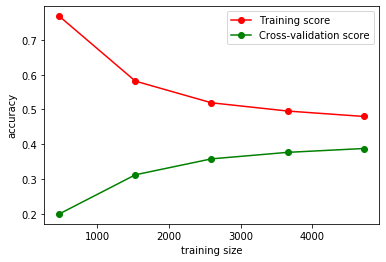

In [180]:
%matplotlib inline
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import numpy as np

c = LogisticRegression(multi_class = 'multinomial', max_iter = 100000, solver = 'newton-cg')
train_sizes, train_scores, valid_scores= \
        learning_curve(c, X_train3, y_train, scoring='accuracy',cv=StratifiedKFold(10),
                       train_sizes=np.linspace(.1, 1.0, 5))
plt.figure()
plt.xlabel("training size")
plt.ylabel("accuracy")
plt.plot(train_sizes,  np.mean(train_scores, axis=1), 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes,  np.mean(valid_scores, axis=1), 'o-', color="g",
                 label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [181]:
train_scores

array([[0.80467091, 0.76433121, 0.76433121, 0.76433121, 0.76433121,
        0.76433121, 0.76433121, 0.76433121, 0.76433121, 0.76433121],
       [0.56368387, 0.54866101, 0.57413455, 0.58523841, 0.59242325,
        0.59046375, 0.59046375, 0.59046375, 0.59046375, 0.59046375],
       [0.5150463 , 0.50964506, 0.5158179 , 0.51890432, 0.51774691,
        0.52083333, 0.52469136, 0.52314815, 0.52314815, 0.52314815],
       [0.4939759 , 0.48685652, 0.48932092, 0.49644031, 0.49069003,
        0.49534502, 0.49671413, 0.50136911, 0.50219058, 0.50219058],
       [0.47825164, 0.47528114, 0.47952472, 0.47740293, 0.47846382,
        0.47846382, 0.47549332, 0.48164651, 0.48822406, 0.48652663]])

In [235]:
train_scores[4].mean()

0.47992785911309144

In [183]:
valid_scores

array([[0.20419847, 0.21564885, 0.19847328, 0.15839695, 0.17557252,
        0.19465649, 0.20801527, 0.208413  , 0.22179732, 0.208413  ],
       [0.29389313, 0.36832061, 0.31870229, 0.29580153, 0.30534351,
        0.29580153, 0.30916031, 0.31357553, 0.31357553, 0.30592734],
       [0.36832061, 0.3740458 , 0.36832061, 0.35305344, 0.33778626,
        0.36832061, 0.3759542 , 0.33843212, 0.3499044 , 0.34416826],
       [0.38931298, 0.41030534, 0.36641221, 0.3778626 , 0.36641221,
        0.3740458 , 0.39694656, 0.36711281, 0.35181644, 0.36520076],
       [0.40458015, 0.41030534, 0.38167939, 0.39122137, 0.3740458 ,
        0.38740458, 0.42366412, 0.38240918, 0.36520076, 0.35564054]])

In [236]:
valid_scores[4].mean()

0.3876151241370251

4.4 - Validation (All features)

In [256]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

c = LogisticRegression(multi_class = 'multinomial', max_iter = 100000, solver = 'newton-cg') # class_weight = 'balanced', solver = 'newton-cg'
c.fit(X_train3, y_train)
y_pred = c.predict(X_valid3)

print(metrics.classification_report(y_valid, y_pred, digits=4))

              precision    recall  f1-score   support

      Action     0.0000    0.0000    0.0000         6
   Adventure     0.0000    0.0000    0.0000         2
   Animation     0.5000    0.3333    0.4000         3
    Children     1.0000    0.3333    0.5000         3
      Comedy     0.4091    0.4737    0.4390        38
       Crime     0.0000    0.0000    0.0000         5
 Documentary     0.5714    0.6667    0.6154        18
       Drama     0.3600    0.6279    0.4576        43
     Fantasy     0.6667    0.3333    0.4444        18
   Film_Noir     0.0000    0.0000    0.0000         4
      Horror     0.3846    0.6250    0.4762         8
     Musical     0.2000    0.1000    0.1333        10
     Mystery     0.0000    0.0000    0.0000        18
     Romance     0.3077    0.3137    0.3107        51
      Sci_Fi     0.4762    0.6250    0.5405        16
    Thriller     0.3846    0.5357    0.4478        28
         War     0.6667    0.2857    0.4000        21
     Western     0.0000    

C:\Users\diego\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5 - Metadata features only

5.1 - Feature selection (Metadata features only)

In [257]:
# drop columns movieId - YTId - title - tag - year
trainSet2 = deepcopy(trainSet1)
trainSet2.drop(columns = ['movieId', 'title', 'YTId', 'tag', 'year'], axis = 1, inplace = True)

# drop columns movieId - YTId - title - tag
validSet1 = deepcopy(validSet)
validSet1.drop(columns = ['movieId', 'title', 'YTId', 'tag', 'year'], axis = 1, inplace = True)

In [258]:
# check dimensions
y_train = trainSet2.iloc[:, 127].values

# check dimensions
y_valid = validSet1.iloc[:, 127].values

yearsTrain1, yearsValid1 = yearsTrain.align(yearsValid, join = 'outer', axis = 1, fill_value = 0)

In [259]:
X_train = pd.concat([yearsTrain1, tagTrainDf, titleTrainDf], axis = 1)

In [260]:
X_valid = pd.concat([yearsValid1, tagValidDf, titleValidDf], axis = 1)

In [261]:
X_train1, X_valid1 = X_train.align(X_valid, join = 'outer', axis = 1, fill_value = 0)

In [262]:
# Save the values
X_train2 = deepcopy(X_train1)
X_valid2 = deepcopy(X_valid1)

In [263]:
#anova test
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func = f_classif, k = 2000)
fit = bestfeatures.fit(X_train2, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train2.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(20, 'Score'))  #print 20 best features

               Specs       Score
1978          war_ta  118.662076
1271         noir_ta   80.839123
440   documentari_ta   73.705935
562            fi_ta   60.914879
1639          sci_ta   60.914879
73           anim_ta   54.865338
842            ii_ta   48.883634
2045        world_ta   48.883634
47          alien_ta   42.873215
1218        music_ta   42.627156
544       fantasi_ta   38.443335
1421        polit_ta   33.574243
436        disney_ta   27.233223
1578       romanc_ta   25.078855
1765        space_ta   24.064837
367         crime_ta   22.269269
810        horror_ta   21.800860
1865     thriller_ta   21.565193
631         fritz_ti   21.336457
468      dystopia_ta   18.557774


C:\Users\diego\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  20   37   38   40   41   50   58   75   78   90   91  103  105  113
  127  128  137  147  150  154  172  177  179  185  198  204  206  211
  212  220  223  224  232  237  243  249  252  255  259  260  261  267
  268  270  274  275  276  278  284  294  297  300  304  305  307  320
  326  333  338  342  350  351  356  359  361  380  381  383  384  385
  394  408  410  423  430  439  444  447  455  456  461  465  470  476
  477  480  483  485  487  489  498  499  505  517  520  521  556  589
  594  601  605  606  612  624  626  635  640  647  649  663  679  681
  689  691  708  712  713  714  715  729  730  741  745  755  761  779
  782  788  791  805  806  808  809  813  820  824  836  837  839  841
  846  852  855  858  870  878  879  882  888  894  895  909  940  942
  949  954  956  973  974  978  980  981  985  987  995 1007 1025 1040
 1045 1057 1059 1062 1073 1

5.2 - Learning Curve (Metadata features only)

In [264]:
bestFeatures = featureScores.nlargest(200,'Score')
X_train3 = X_train2[bestFeatures['Specs']]
X_valid3 = X_valid2[bestFeatures['Specs']]

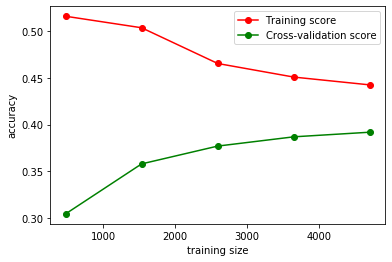

In [200]:
%matplotlib inline
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import numpy as np

c = LogisticRegression(multi_class = 'multinomial', max_iter = 100000, solver = 'newton-cg')
train_sizes2, train_scores2, valid_scores2= \
        learning_curve(c, X_train3, y_train, scoring='accuracy',cv=StratifiedKFold(10),
                       train_sizes=np.linspace(.1, 1.0, 5))
plt.figure()
plt.xlabel("training size")
plt.ylabel("accuracy")
plt.plot(train_sizes2,  np.mean(train_scores2, axis=1), 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes2,  np.mean(valid_scores2, axis=1), 'o-', color="g",
                 label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [201]:
train_scores2

array([[0.56050955, 0.52441614, 0.50955414, 0.50955414, 0.50955414,
        0.50955414, 0.50955414, 0.50955414, 0.50955414, 0.50955414],
       [0.48465056, 0.47093403, 0.49836708, 0.51469628, 0.50881777,
        0.51208361, 0.51208361, 0.51208361, 0.51208361, 0.51208361],
       [0.4533179 , 0.44945988, 0.45794753, 0.46412037, 0.46990741,
        0.46682099, 0.47299383, 0.47337963, 0.47337963, 0.47337963],
       [0.44112815, 0.43948521, 0.44523549, 0.45208105, 0.45427163,
        0.45016429, 0.45317634, 0.4611172 , 0.45618839, 0.45618839],
       [0.43369404, 0.43496711, 0.43878634, 0.44302992, 0.44791004,
        0.44302992, 0.44027159, 0.44918311, 0.44387863, 0.45045619]])

In [239]:
train_scores2[4].mean()

0.44252068746021644

In [203]:
valid_scores2

array([[0.35114504, 0.36450382, 0.28816794, 0.28625954, 0.26717557,
        0.28244275, 0.28244275, 0.28871893, 0.32695985, 0.3040153 ],
       [0.41412214, 0.41793893, 0.35877863, 0.34923664, 0.33969466,
        0.35687023, 0.34923664, 0.33843212, 0.33652008, 0.31739962],
       [0.43129771, 0.42748092, 0.38549618, 0.37977099, 0.34160305,
        0.37022901, 0.37977099, 0.35946463, 0.36137667, 0.33269598],
       [0.45038168, 0.4351145 , 0.41030534, 0.39122137, 0.35305344,
        0.39122137, 0.39312977, 0.31357553, 0.37858509, 0.35181644],
       [0.44465649, 0.44083969, 0.41793893, 0.39503817, 0.36068702,
        0.39122137, 0.41030534, 0.35755258, 0.36902486, 0.33078394]])

In [240]:
valid_scores2[4].mean()

0.3918048399573803

5.3 - Validation (Metadata features only)

In [266]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

c = LogisticRegression(multi_class = 'multinomial', max_iter = 100000, solver = 'newton-cg') # class_weight = 'balanced', solver = 'newton-cg'
c.fit(X_train3, y_train)
y_pred = c.predict(X_valid3)

print(metrics.classification_report(y_valid, y_pred, digits=4))

              precision    recall  f1-score   support

      Action     0.0000    0.0000    0.0000         6
   Adventure     0.0000    0.0000    0.0000         2
   Animation     0.0000    0.0000    0.0000         3
    Children     0.0000    0.0000    0.0000         3
      Comedy     0.4390    0.4737    0.4557        38
       Crime     0.0000    0.0000    0.0000         5
 Documentary     0.6154    0.4444    0.5161        18
       Drama     0.2857    0.6512    0.3972        43
     Fantasy     0.4286    0.1667    0.2400        18
   Film_Noir     1.0000    0.2500    0.4000         4
      Horror     0.4444    0.5000    0.4706         8
     Musical     0.2000    0.1000    0.1333        10
     Mystery     1.0000    0.0556    0.1053        18
     Romance     0.2951    0.3529    0.3214        51
      Sci_Fi     0.5455    0.7500    0.6316        16
    Thriller     0.4231    0.3929    0.4074        28
         War     0.7273    0.3810    0.5000        21
     Western     0.0000    

C:\Users\diego\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6 - Audio/Visual features only

6.1 - Feature selection (Audio/Visual features only)

In [267]:
# drop columns movieId - YTId - title - tag - year
trainSet2 = deepcopy(trainSet1)
trainSet2.drop(columns = ['movieId', 'title', 'YTId', 'tag', 'year'], axis = 1, inplace = True)

# drop columns movieId - YTId - title - tag
validSet1 = deepcopy(validSet)
validSet1.drop(columns = ['movieId', 'title', 'YTId', 'tag', 'year'], axis = 1, inplace = True)

In [268]:
# check dimensions
y_train = trainSet2.iloc[:, 127].values
XAuxTrain = trainSet2.iloc[:, 0:127]

# check dimensions
y_valid = validSet1.iloc[:, 127].values
XAuxValid = validSet1.iloc[:, 0:127]

# Feature Scaling
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
XAuxTrain1, XAuxValid1 = XAuxTrain.align(XAuxValid, join = 'outer', axis = 1, fill_value = 0)

XAuxTrain_Sc = pd.DataFrame(ss.fit_transform(XAuxTrain1),columns = XAuxTrain1.columns)
XAuxValid_Sc = pd.DataFrame(ss.transform(XAuxValid1),columns = XAuxValid1.columns)

In [269]:
X_train = deepcopy(XAuxTrain_Sc)

In [270]:
X_valid = deepcopy(XAuxValid_Sc)

In [271]:
X_train1, X_valid1 = X_train.align(X_valid, join = 'outer', axis = 1, fill_value = 0)

In [272]:
# Save the values
X_train2 = deepcopy(X_train1)
X_valid2 = deepcopy(X_valid1)

In [273]:
#anova test
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func = f_classif, k = 127)
fit = bestfeatures.fit(X_train2, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train2.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(20, 'Score'))  #print 20 best features

    Specs      Score
6    avf7  38.646457
32  avf33  33.176945
5    avf6  31.645255
77  avf78  30.259596
52  avf53  30.218690
2    avf3  29.632619
82  avf83  27.196010
4    avf5  26.189013
25  avf26  25.804035
55  avf56  25.779550
27  avf28  23.653769
35  avf36  22.801135
9   avf10  21.851837
28  avf29  21.549177
36  avf37  20.892896
33  avf34  19.391341
12  avf13  18.649122
37  avf38  17.941044
14  avf15  17.106703
26  avf27  16.828212


C:\Users\diego\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 30  31 103] are constant.
  UserWarning)
C:\Users\diego\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


6.2 - Learning Curve (Audio/Visual features only)

In [274]:
bestFeatures = featureScores.nlargest(127,'Score')
X_train3 = X_train2[bestFeatures['Specs']]
X_valid3 = X_valid2[bestFeatures['Specs']]

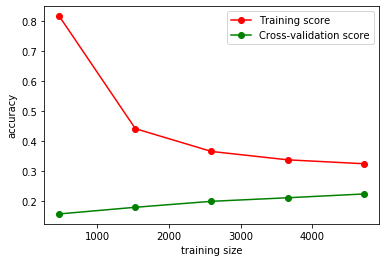

In [219]:
%matplotlib inline
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import numpy as np

c = LogisticRegression(multi_class = 'multinomial', max_iter = 100000, solver = 'newton-cg')
train_sizes4, train_scores4, valid_scores4= \
        learning_curve(c, X_train3, y_train, scoring='accuracy',cv=StratifiedKFold(10),
                       train_sizes=np.linspace(.1, 1.0, 5))
plt.figure()
plt.xlabel("training size")
plt.ylabel("accuracy")
plt.plot(train_sizes4,  np.mean(train_scores4, axis=1), 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes4,  np.mean(valid_scores4, axis=1), 'o-', color="g",
                 label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [220]:
train_scores4

array([[0.85774947, 0.81104034, 0.81316348, 0.81316348, 0.81316348,
        0.81316348, 0.81316348, 0.81316348, 0.81316348, 0.81316348],
       [0.47485304, 0.45395167, 0.45264533, 0.43435663, 0.43566297,
        0.4350098 , 0.4350098 , 0.4350098 , 0.4350098 , 0.4350098 ],
       [0.35725309, 0.3753858 , 0.37770062, 0.36496914, 0.35300926,
        0.37692901, 0.36574074, 0.36496914, 0.36496914, 0.36496914],
       [0.34200438, 0.3458379 , 0.34090909, 0.33680175, 0.33351588,
        0.34337349, 0.34118291, 0.33214677, 0.33543264, 0.33543264],
       [0.33121154, 0.32781668, 0.32527053, 0.32336092, 0.31996605,
        0.32993847, 0.32123913, 0.3235731 , 0.32420963, 0.33015065]])

In [243]:
train_scores4[4].mean()

0.32567366857627833

In [222]:
valid_scores4

array([[0.14312977, 0.16984733, 0.15076336, 0.14122137, 0.17938931,
        0.15839695, 0.15076336, 0.14531549, 0.1873805 , 0.15678776],
       [0.15648855, 0.20038168, 0.18320611, 0.18129771, 0.18129771,
        0.17938931, 0.17748092, 0.18546845, 0.17208413, 0.1873805 ],
       [0.19083969, 0.20801527, 0.18129771, 0.21374046, 0.20992366,
        0.20038168, 0.1870229 , 0.20458891, 0.21032505, 0.19694073],
       [0.19465649, 0.20610687, 0.20801527, 0.20801527, 0.21374046,
        0.21755725, 0.21755725, 0.21223709, 0.2332696 , 0.21032505],
       [0.20610687, 0.21183206, 0.21183206, 0.23473282, 0.22137405,
        0.21374046, 0.22519084, 0.24474187, 0.24282983, 0.23518164]])

In [244]:
valid_scores4[4].mean()

0.22475625063856497

6.3 - Validation (Audio/Visual features only)

In [275]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

c = LogisticRegression(multi_class = 'multinomial', max_iter = 100000, solver = 'newton-cg') # class_weight = 'balanced', solver = 'newton-cg'
c.fit(X_train3, y_train)
y_pred = c.predict(X_valid3)

print(metrics.classification_report(y_valid, y_pred, digits=4))

              precision    recall  f1-score   support

      Action     0.0000    0.0000    0.0000         6
   Adventure     0.0000    0.0000    0.0000         2
   Animation     0.5000    0.6667    0.5714         3
    Children     0.0000    0.0000    0.0000         3
      Comedy     0.3846    0.5263    0.4444        38
       Crime     0.0000    0.0000    0.0000         5
 Documentary     0.5217    0.6667    0.5854        18
       Drama     0.3023    0.3023    0.3023        43
     Fantasy     0.3333    0.2222    0.2667        18
   Film_Noir     0.0000    0.0000    0.0000         4
      Horror     0.2727    0.3750    0.3158         8
     Musical     0.2857    0.2000    0.2353        10
     Mystery     0.0000    0.0000    0.0000        18
     Romance     0.3171    0.2549    0.2826        51
      Sci_Fi     0.1818    0.2500    0.2105        16
    Thriller     0.2712    0.5714    0.3678        28
         War     0.2000    0.0952    0.1290        21
     Western     0.0000    

C:\Users\diego\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
